In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

def load():
    data = pd.read_csv("titanic.csv")
    return data

df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [2]:
df.isnull().values.any()

True

In [3]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [27]:
df[df.isnull().any(axis=1)].head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.000,0.000,3.000,"Braund, Mr. Owen Harris",male,22.000,1.000,0.000,A/5 21171,7.250,NaN,S
2,3.000,1.000,3.000,"Heikkinen, Miss. Laina",female,26.000,0.000,0.000,STON/O2. 3101282,7.925,NaN,S
4,5.000,0.000,3.000,"Allen, Mr. William Henry",male,35.000,0.000,0.000,373450,8.050,NaN,S


In [28]:
ratio=(df.isnull().sum() / df.shape[0]*100).sort_values(ascending=False)
ratio

Cabin         77.104
Embarked       0.224
PassengerId    0.000
Survived       0.000
Pclass         0.000
Name           0.000
Sex            0.000
Age            0.000
SibSp          0.000
Parch          0.000
Ticket         0.000
Fare           0.000
dtype: float64

In [30]:
na_cols = [col for col in df.columns if df[col].isnull().sum()>0]
na_cols

['Cabin', 'Embarked']

In [7]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns



In [8]:
missing_values_table(df)

          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220


In [9]:
df["Age"].isnull().sum()

177

In [10]:
df["Age"]=df["Age"].fillna(df["Age"].mean())

In [11]:
df["Age"].isnull().sum()

0

In [12]:
df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [13]:
df.apply( lambda x:x.fillna(x.mode()[0]) if x.dtype == "O" and len(x.unique()) else x, axis=0).isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [14]:
df.groupby("Sex")["Age"].mean()

Sex
female   28.217
male     30.506
Name: Age, dtype: float64

In [15]:
df.loc[(df["Age"].isnull())&(df["Sex"]=="female"),"Age"] = df.groupby("Sex")["Age"].mean()["female"]

In [16]:
df.loc[(df["Age"].isnull())&(df["Sex"]=="male")]= df.groupby("Sex")["Age"].mean()["male"]

In [38]:
def grab_col_name(dataframe,cat_th=10,car_th=20):
    cat_cols    =  [col for col in dataframe.columns if dataframe[col].dtype == ("O")]
    num_but_cat =  [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtype !="O"]
    cat_but_car =  [col for col in dataframe.columns if dataframe[col].nunique() < car_th and dataframe[col].dtype == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype !="O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"observations:{dataframe.shape[0]}")
    print(f"variables:{dataframe.shape[1]}")
    print(f'cat_cols:{len(cat_cols)}')
    print(f'num_cols:{len(num_cols)}')
    print(f'cat_but_car:{len(cat_but_car)}')
    print(f'num_but_car:{len(num_but_cat)}')
    return cat_cols,num_cols,cat_but_car

In [18]:
cat_cols,num_cols,cat_but_car = grab_col_name(df)
num_cols=[col for col in num_cols if col not in "PassengerId"]

observations:891
variables:12
cat_cols:4
num_cols:3
cat_but_car:2
num_but_car:4


In [19]:
dff = pd.get_dummies(df[cat_cols+num_cols],drop_first=True)
dff.head()

,Survived,Pclass,SibSp,Parch,Age,Fare
0,0.000,3.000,1.000,0.000,22.000,7.250
1,1.000,1.000,1.000,0.000,38.000,71.283
2,1.000,3.000,0.000,0.000,26.000,7.925
3,1.000,1.000,1.000,0.000,35.000,53.100
4,0.000,3.000,0.000,0.000,35.000,8.050


In [20]:
scaler =MinMaxScaler()
dff = pd.DataFrame(scaler.fit_transform(dff),columns=dff.columns)
dff.head()

,Survived,Pclass,SibSp,Parch,Age,Fare
0,0.000,1.000,0.125,0.000,0.271,0.014
1,1.000,0.000,0.125,0.000,0.472,0.139
2,1.000,1.000,0.000,0.000,0.321,0.015
3,1.000,0.000,0.125,0.000,0.435,0.104
4,0.000,1.000,0.000,0.000,0.435,0.016


In [21]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
dff=pd.DataFrame(imputer.fit_transform(dff),columns=dff.columns)
dff.head(10)

,Survived,Pclass,SibSp,Parch,Age,Fare
0,0.000,1.000,0.125,0.000,0.271,0.014
1,1.000,0.000,0.125,0.000,0.472,0.139
2,1.000,1.000,0.000,0.000,0.321,0.015
3,1.000,0.000,0.125,0.000,0.435,0.104
4,0.000,1.000,0.000,0.000,0.435,0.016
5,0.000,1.000,0.000,0.000,0.368,0.017
6,0.000,0.000,0.000,0.000,0.673,0.101
7,0.000,1.000,0.375,0.167,0.020,0.041
8,1.000,1.000,0.000,0.333,0.334,0.022
9,1.000,0.500,0.125,0.000,0.171,0.059


<AxesSubplot:>

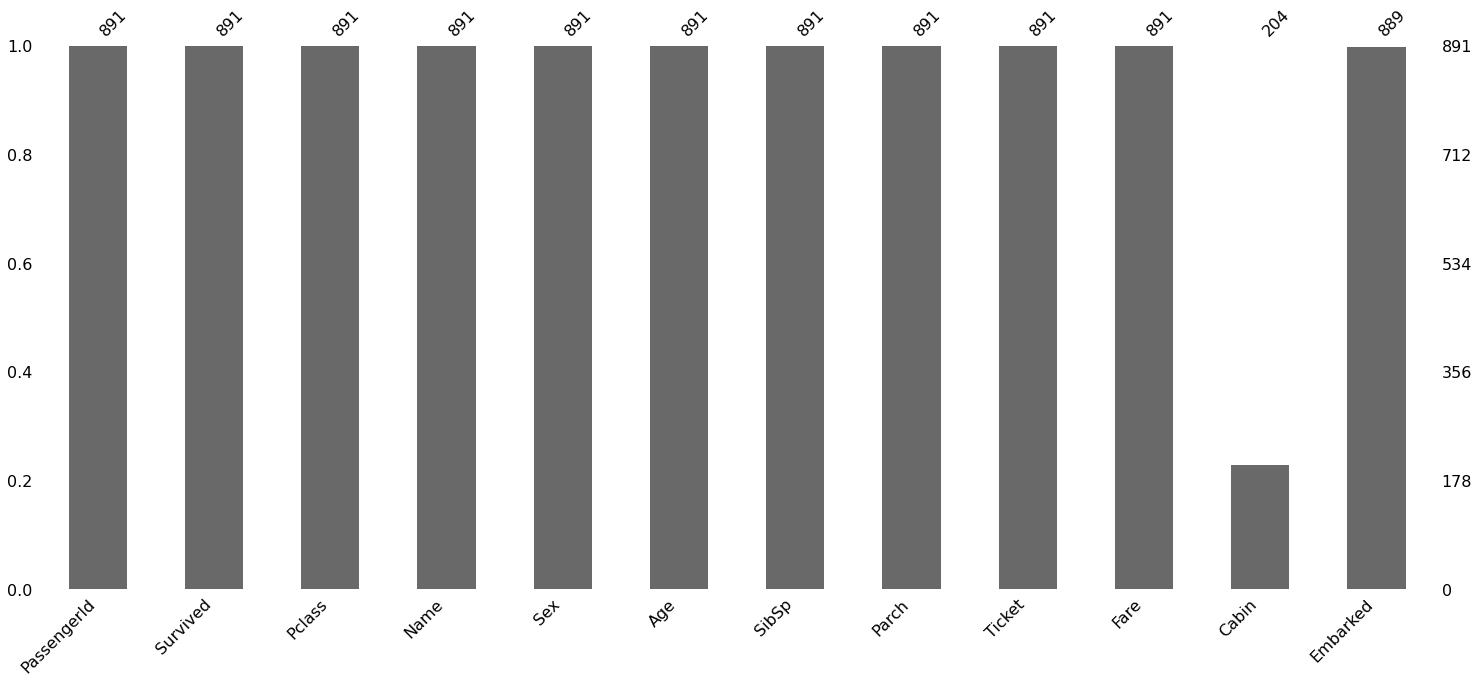

In [22]:
msno.bar(df)

<AxesSubplot:>

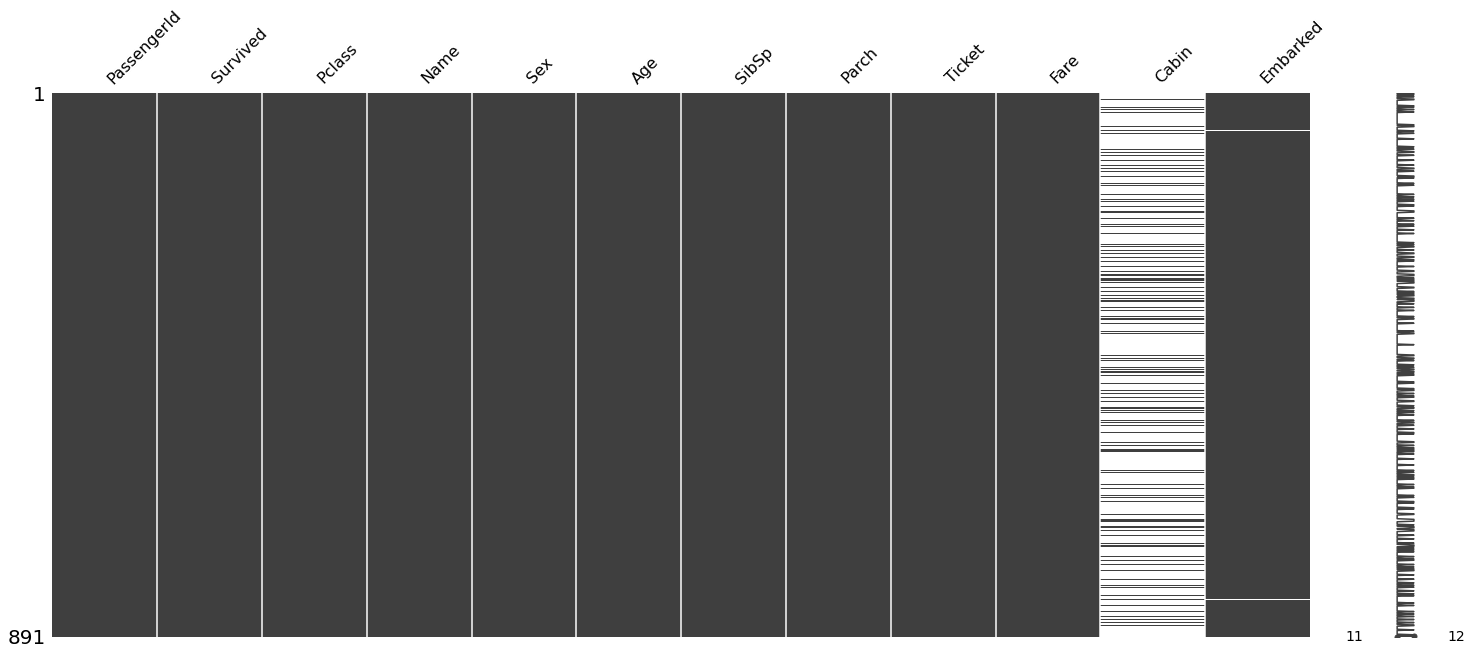

In [23]:
msno.matrix(df)

<AxesSubplot:>

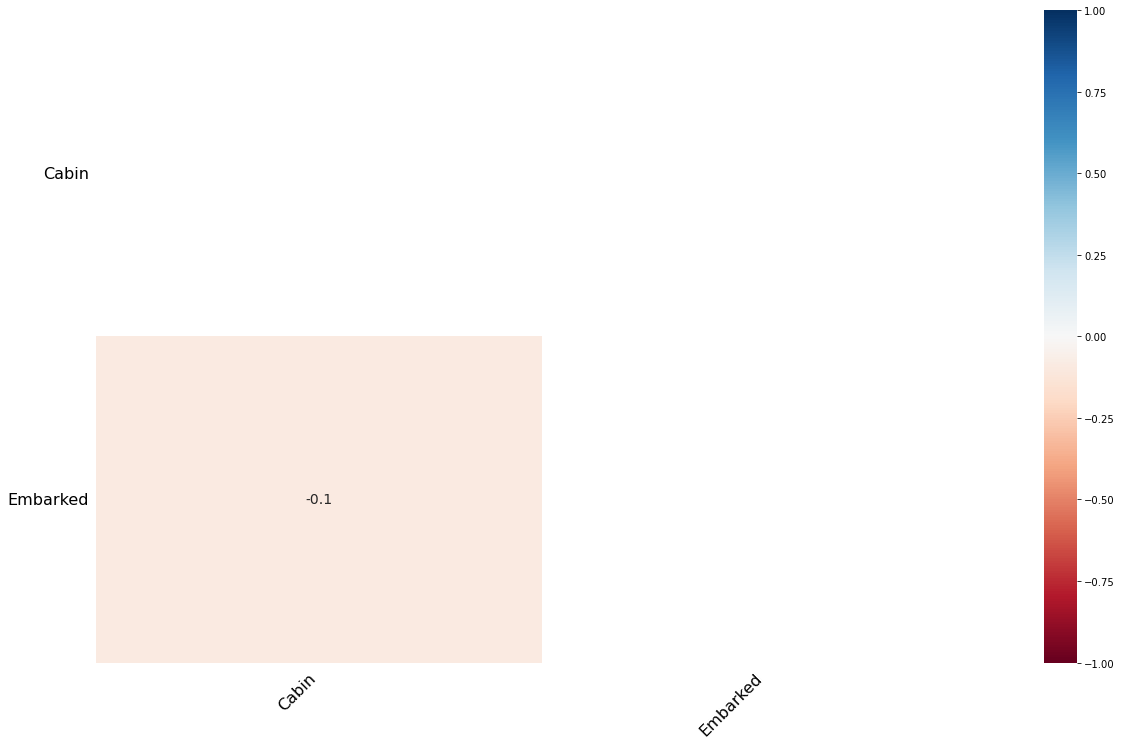

In [24]:
msno.heatmap(df)

In [25]:
na_cols= missing_values_table(df,True)


          n_miss  ratio
Cabin        687 77.100
Embarked       2  0.220


In [43]:
def missig_vs_target(dataframe,target,na_columns):
    for col in dataframe.columns:
        dataframe[col+'_NA_FLAH']=np.where(dataframe[col].isnull(),1,0)
        na_flag=dataframe.loc[:,dataframe.columns.str.contains("_NA_")].columns
    for col in na_flag:
        print(pd.DataFrame({"TARGET_MEAN":dataframe.groupby(col)[target].mean(),
                             "Count":dataframe.groupby(col)[target].count()
        }), end="\n\n\n")

In [44]:
missig_vs_target(df,"Survived",na_cols)

                     TARGET_MEAN  Count
PassengerId_NA_FLAH                    
0                          0.384    891


                  TARGET_MEAN  Count
Survived_NA_FLAH                    
0                       0.384    891


                TARGET_MEAN  Count
Pclass_NA_FLAH                    
0                     0.384    891


              TARGET_MEAN  Count
Name_NA_FLAH                    
0                   0.384    891


             TARGET_MEAN  Count
Sex_NA_FLAH                    
0                  0.384    891


             TARGET_MEAN  Count
Age_NA_FLAH                    
0                  0.384    891


               TARGET_MEAN  Count
SibSp_NA_FLAH                    
0                    0.384    891


               TARGET_MEAN  Count
Parch_NA_FLAH                    
0                    0.384    891


                TARGET_MEAN  Count
Ticket_NA_FLAH                    
0                     0.384    891


              TARGET_MEAN  Count
Fare_NA_FLAH 